# InfoGAN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.autograd as autograd
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
#Visualization Tool requires "pip install visdom" (https://github.com/facebookresearch/visdom)
# from visdom_utils import VisFunc
# vf = VisFunc(enval='infoGAN') # Visdom

## MNIST Dataset

In [7]:
batch_size = 100
dataset = dset.MNIST('./dataset', transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

## Define Model

In [8]:
# Feather Extractor
class FrontEnd(nn.Module):
    def __init__(self):
        super(FrontEnd, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(1,64,4,2,1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64,128,4,2,1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 1024,7,bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self,x):
        output = self.main(x)
        return output

In [9]:
# Discriminator
class Dmodel(nn.Module):
    def __init__(self):
        super(Dmodel, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1024,1,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        output=self.main(x).view(-1,1)
        return output

In [10]:
# Classifier Q
class Qmodel(nn.Module):
    def __init__(self):
        super(Qmodel,self).__init__()

        self.conv = nn.Conv2d(1024,128,1,bias=False)
        self.bn = nn.BatchNorm2d(128)
        self.lReLU = nn.LeakyReLU(0.1, inplace=True)
        self.conv_disc = nn.Conv2d(128,10,1)
        self.conv_mu = nn.Conv2d(128,2,1)
        self.conv_var = nn.Conv2d(128,2,1)

    def forward(self,x):
        y = self.conv(x)
        disc_logits = self.conv_disc(y).squeeze()
        mu = self.conv_mu(y).squeeze()
        var = self.conv_var(y).squeeze().exp()
        return disc_logits, mu, var

In [11]:
# Generator
class Gmodel(nn.Module):
    def __init__(self):
        super(Gmodel, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(74, 1024,1,1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 128,7,1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,1,4,2,1,bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output


In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    
# Models
FE=FrontEnd()
D=Dmodel()
Q=Qmodel()
G=Gmodel()

for i in [FE, D, Q, G]:
    i.cuda()
    i.apply(weights_init)

## Defin Losses & Optimizer

![log_gaussian](https://user-images.githubusercontent.com/613623/30778123-7328abc0-a0cd-11e7-8998-7e4ef07cc25f.png)
https://user-images.githubusercontent.com/613623/30778123-7328abc0-a0cd-11e7-8998-7e4ef07cc25f.png

In [13]:
# Define Losses
class log_gaussian:
    def __call__(self, x, mu, var):
        logli = -0.5*(var.mul(2*np.pi)+1e-6).log() - (x-mu).pow(2).div(var.mul(2.0)+1e-6)
        return logli.sum(1).mean().mul(-1)

criterionD = nn.BCELoss()
criterionQ_dis = nn.CrossEntropyLoss()
criterionQ_con = log_gaussian()

In [14]:
# Optimizers
optimD = optim.Adam([{'params':FE.parameters()},
                     {'params':D.parameters()}],
                    lr=0.0002, betas=(0.5, 0.99))

optimG = optim.Adam([{'params':G.parameters()},
                     {'params':Q.parameters()}],
                    lr=0.001, betas=(0.5, 0.99))

## Define Inputs Codes

In [15]:
# fixed random variables for test
c0 = torch.linspace(-1,1,10).view(-1,1).repeat(10,0)
c1 = torch.stack((c0, torch.zeros(1).expand_as(c0)),1).cuda()
c2 = torch.stack((torch.zeros(1).expand_as(c0), c0),1).cuda()
one_hot = torch.eye(10).repeat(1,1,10).view(batch_size,10).cuda()
fix_noise = torch.Tensor(batch_size, 62).uniform_(-1, 1).cuda()

# random noises sampling function
def _noise_sample(dis_c, con_c, noise, bs):
    idx = np.random.randint(10, size=bs)
    c = np.zeros((bs, 10))
    c[range(bs),idx] = 1.0
    dis_c.data.copy_(torch.Tensor(c))
    con_c.data.uniform_(-1.0, 1.0)
    noise.data.uniform_(-1.0, 1.0)
    z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
    return z, idx

## Training

Epoch:0, Iter:0, Dloss: [ 1.41543877], Gloss: [ 3.28297949], Preal: 0.4989894926548004, Pfake: 0.47352924942970276


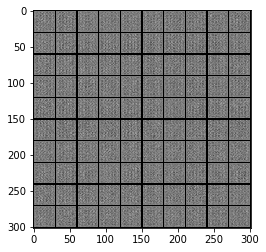

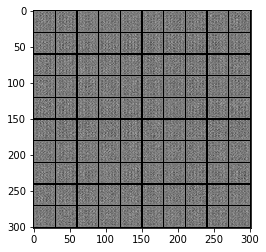

Epoch:0, Iter:100, Dloss: [ 1.15550184], Gloss: [ 1.56233799], Preal: 0.5808821320533752, Pfake: 0.3596343994140625


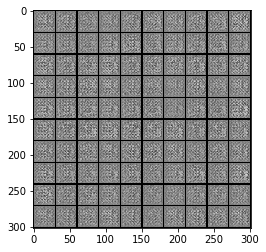

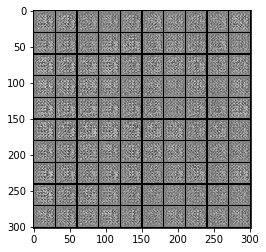

Epoch:0, Iter:200, Dloss: [ 0.8942979], Gloss: [ 1.31922793], Preal: 0.626133143901825, Pfake: 0.3022608757019043


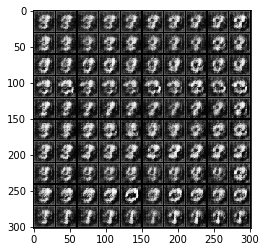

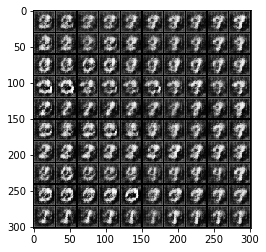

Epoch:0, Iter:300, Dloss: [ 1.1423409], Gloss: [ 0.991292], Preal: 0.5899667143821716, Pfake: 0.39171653985977173


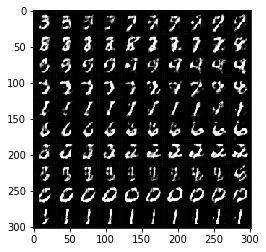

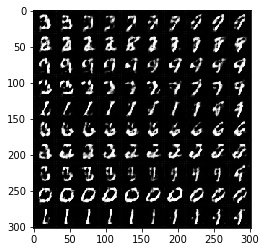

Epoch:0, Iter:400, Dloss: [ 1.09408545], Gloss: [ 1.14138258], Preal: 0.5963670611381531, Pfake: 0.38363850116729736


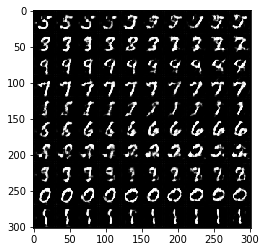

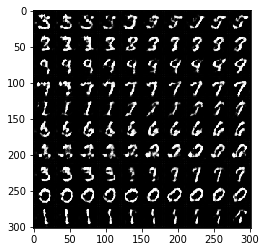

Epoch:0, Iter:500, Dloss: [ 1.18279433], Gloss: [ 0.9603045], Preal: 0.5798404216766357, Pfake: 0.40804827213287354


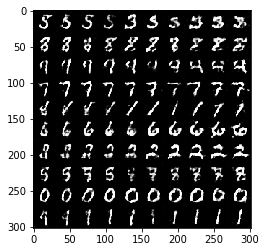

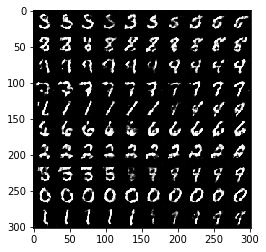

Epoch:1, Iter:0, Dloss: [ 1.1713891], Gloss: [ 0.9238115], Preal: 0.5572465658187866, Pfake: 0.3948398530483246


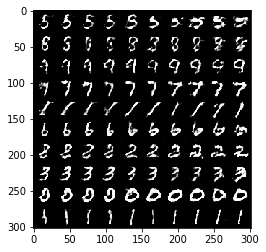

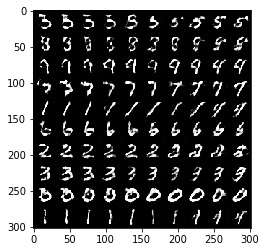

Epoch:1, Iter:100, Dloss: [ 1.20063615], Gloss: [ 0.93630183], Preal: 0.5446969270706177, Pfake: 0.4001072347164154


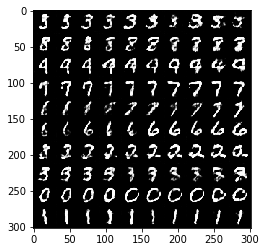

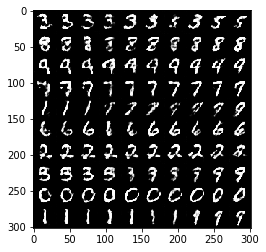

Epoch:1, Iter:200, Dloss: [ 1.25660753], Gloss: [ 0.90513724], Preal: 0.5353402495384216, Pfake: 0.399657279253006


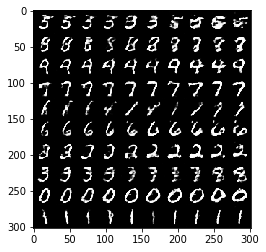

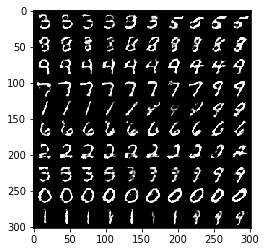

Epoch:1, Iter:300, Dloss: [ 1.17480683], Gloss: [ 1.00931919], Preal: 0.5952338576316833, Pfake: 0.39794597029685974


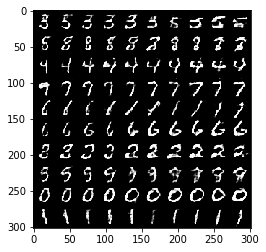

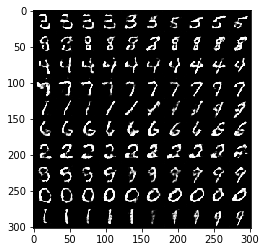

Epoch:1, Iter:400, Dloss: [ 1.1475215], Gloss: [ 0.97569925], Preal: 0.561705470085144, Pfake: 0.37399569153785706


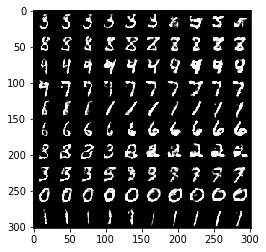

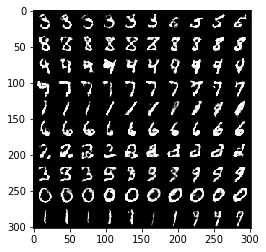

Epoch:1, Iter:500, Dloss: [ 1.17127132], Gloss: [ 0.89868325], Preal: 0.5861759781837463, Pfake: 0.38642340898513794


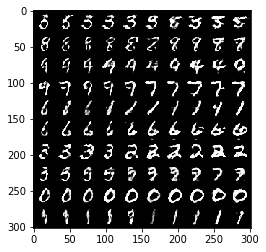

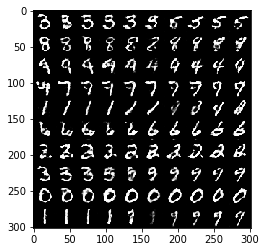

Epoch:2, Iter:0, Dloss: [ 1.25180101], Gloss: [ 0.87956607], Preal: 0.5548540949821472, Pfake: 0.4084799289703369


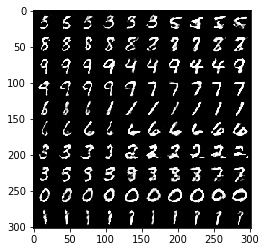

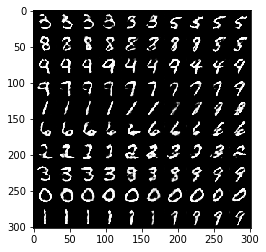

Epoch:2, Iter:100, Dloss: [ 1.15293777], Gloss: [ 0.98787355], Preal: 0.5589383840560913, Pfake: 0.3703896403312683


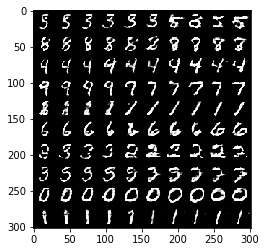

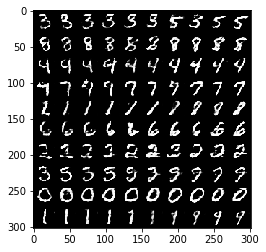

Epoch:2, Iter:200, Dloss: [ 1.20435059], Gloss: [ 0.91231954], Preal: 0.5638324618339539, Pfake: 0.39871010184288025


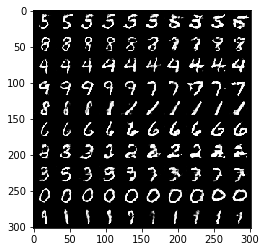

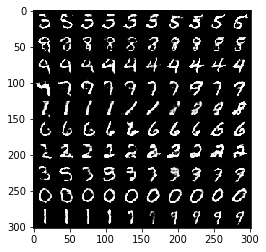

Epoch:2, Iter:300, Dloss: [ 1.18293953], Gloss: [ 0.99826968], Preal: 0.5855516195297241, Pfake: 0.39515942335128784


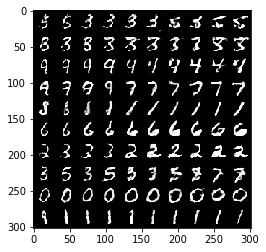

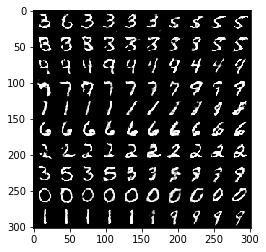

Epoch:2, Iter:400, Dloss: [ 1.20805228], Gloss: [ 0.8987785], Preal: 0.5698521733283997, Pfake: 0.402436226606369


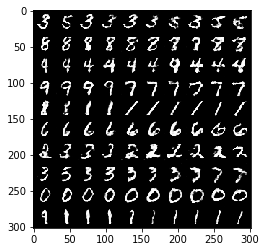

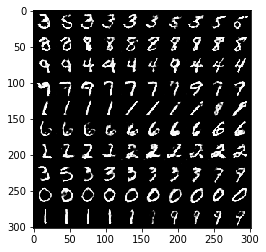

Epoch:2, Iter:500, Dloss: [ 1.20182121], Gloss: [ 0.90932679], Preal: 0.5676581859588623, Pfake: 0.40195465087890625


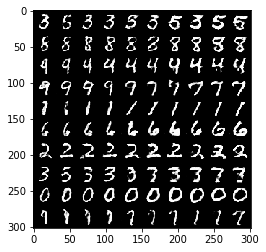

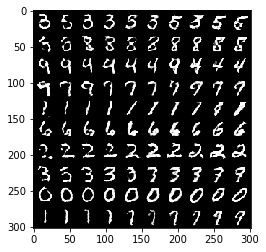

Epoch:3, Iter:0, Dloss: [ 1.16026855], Gloss: [ 0.9236055], Preal: 0.5788894891738892, Pfake: 0.38560763001441956


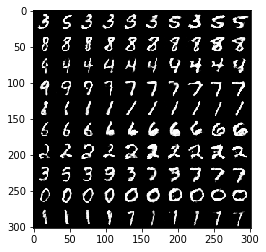

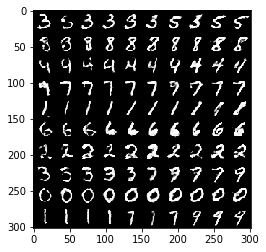

Epoch:3, Iter:100, Dloss: [ 1.2282685], Gloss: [ 0.89197546], Preal: 0.5541107654571533, Pfake: 0.40466004610061646


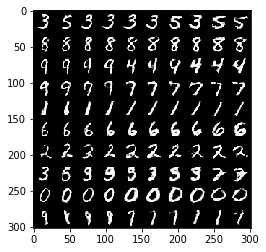

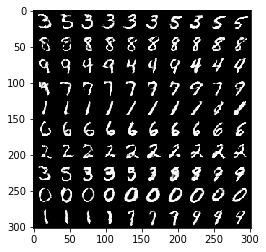

Epoch:3, Iter:200, Dloss: [ 1.26475728], Gloss: [ 0.93558097], Preal: 0.5458717942237854, Pfake: 0.4111381471157074


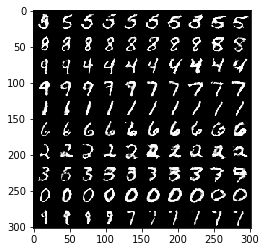

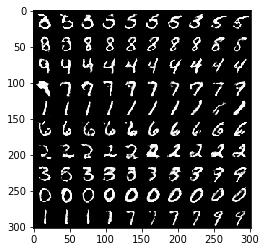

Epoch:3, Iter:300, Dloss: [ 1.22285271], Gloss: [ 0.88892561], Preal: 0.5809452533721924, Pfake: 0.40631771087646484


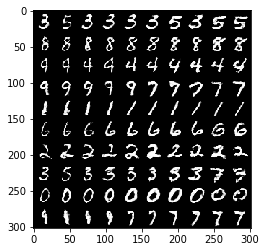

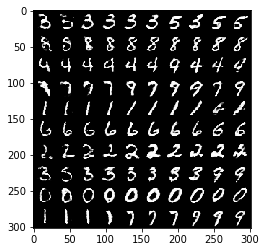

Epoch:3, Iter:400, Dloss: [ 1.16394329], Gloss: [ 0.98789698], Preal: 0.5789663195610046, Pfake: 0.3885008990764618


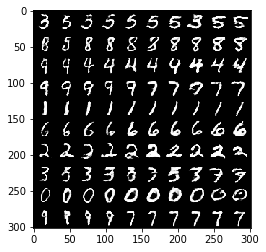

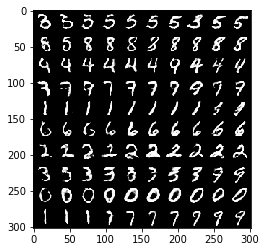

Epoch:3, Iter:500, Dloss: [ 1.2078985], Gloss: [ 1.02539027], Preal: 0.5575060248374939, Pfake: 0.3834269642829895


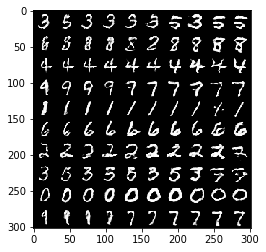

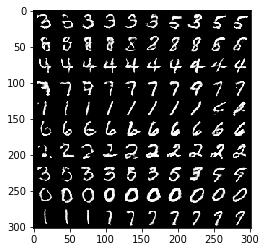

Epoch:4, Iter:0, Dloss: [ 1.16049051], Gloss: [ 0.93921345], Preal: 0.588477373123169, Pfake: 0.39326807856559753


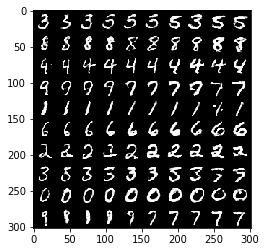

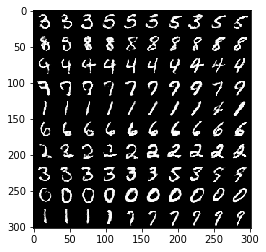

Epoch:4, Iter:100, Dloss: [ 1.20092559], Gloss: [ 0.92651415], Preal: 0.5616093277931213, Pfake: 0.40068650245666504


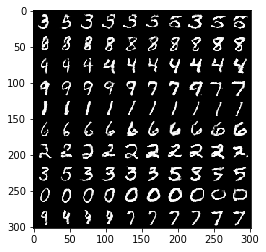

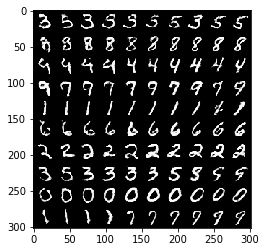

Epoch:4, Iter:200, Dloss: [ 1.20425153], Gloss: [ 0.93913686], Preal: 0.5707940459251404, Pfake: 0.3967353403568268


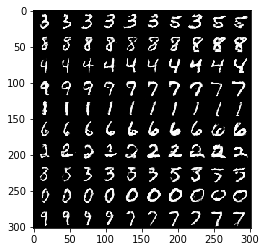

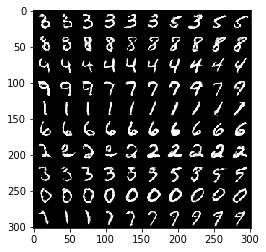

Epoch:4, Iter:300, Dloss: [ 1.23924446], Gloss: [ 0.88440025], Preal: 0.5733205080032349, Pfake: 0.4018065929412842


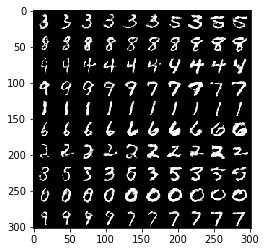

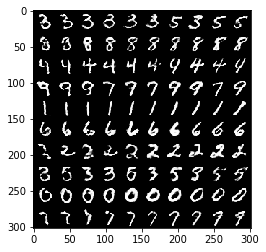

Epoch:4, Iter:400, Dloss: [ 1.26102614], Gloss: [ 0.99891686], Preal: 0.5580064654350281, Pfake: 0.39633265137672424


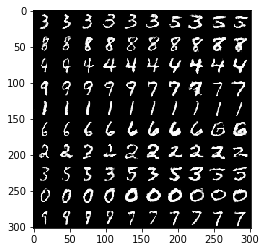

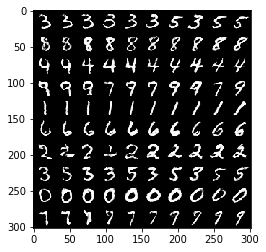

Epoch:4, Iter:500, Dloss: [ 1.26202285], Gloss: [ 0.9024272], Preal: 0.531842827796936, Pfake: 0.38751694560050964


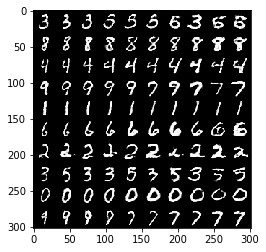

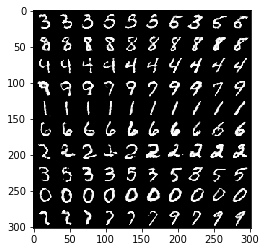

Epoch:5, Iter:0, Dloss: [ 1.35753441], Gloss: [ 0.90105969], Preal: 0.5306021571159363, Pfake: 0.40292224287986755


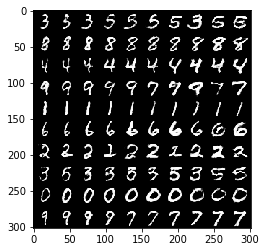

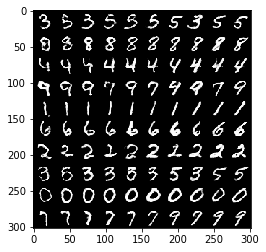

Epoch:5, Iter:100, Dloss: [ 1.214504], Gloss: [ 1.01701307], Preal: 0.5534490942955017, Pfake: 0.37437304854393005


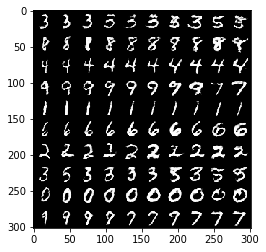

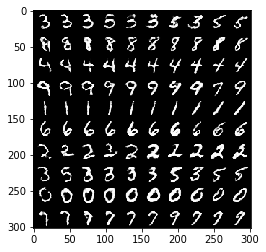

Epoch:5, Iter:200, Dloss: [ 1.21379733], Gloss: [ 0.97111285], Preal: 0.5493016242980957, Pfake: 0.37148869037628174


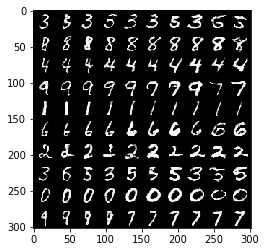

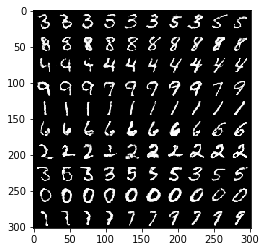

Epoch:5, Iter:300, Dloss: [ 1.21173692], Gloss: [ 0.88364679], Preal: 0.5654522180557251, Pfake: 0.39395636320114136


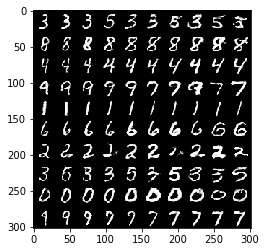

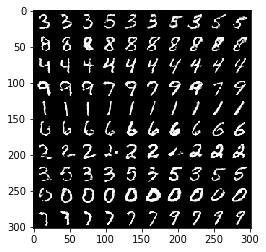

Epoch:5, Iter:400, Dloss: [ 1.22194529], Gloss: [ 0.92285281], Preal: 0.5672948956489563, Pfake: 0.3924591541290283


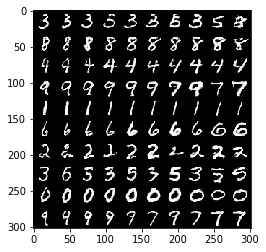

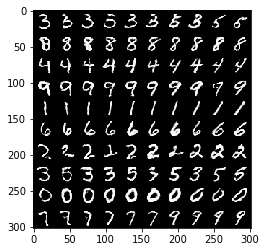

Epoch:5, Iter:500, Dloss: [ 1.19278097], Gloss: [ 0.89051336], Preal: 0.5864172577857971, Pfake: 0.41519930958747864


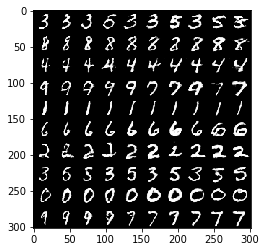

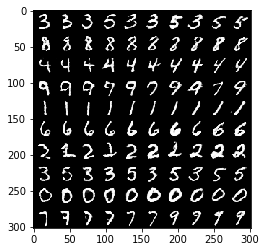

Epoch:6, Iter:0, Dloss: [ 1.09049129], Gloss: [ 0.9315812], Preal: 0.6183837652206421, Pfake: 0.3761266767978668


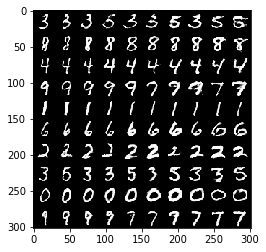

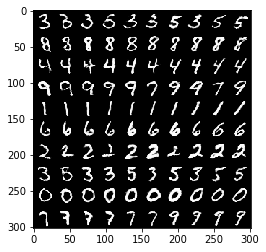

Epoch:6, Iter:100, Dloss: [ 1.20330262], Gloss: [ 0.88038963], Preal: 0.5719993114471436, Pfake: 0.39634352922439575


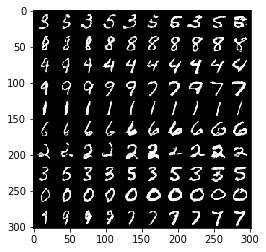

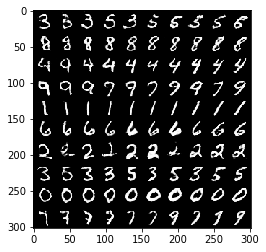

Epoch:6, Iter:200, Dloss: [ 1.20155454], Gloss: [ 0.93760049], Preal: 0.5562921166419983, Pfake: 0.37431660294532776


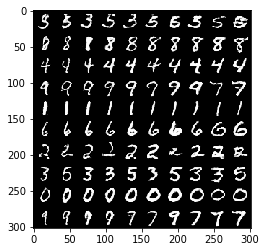

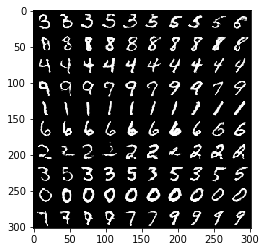

Epoch:6, Iter:300, Dloss: [ 1.16874611], Gloss: [ 0.96186304], Preal: 0.56313556432724, Pfake: 0.3723355829715729


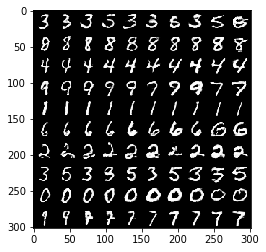

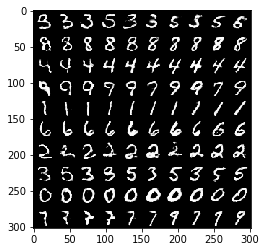

Epoch:6, Iter:400, Dloss: [ 1.26532078], Gloss: [ 0.78994399], Preal: 0.5576592087745667, Pfake: 0.42299774289131165


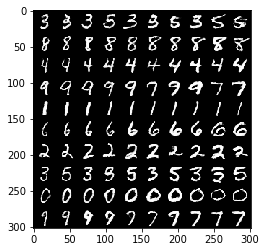

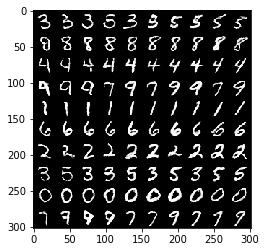

Epoch:6, Iter:500, Dloss: [ 1.23437834], Gloss: [ 0.9105137], Preal: 0.5846911072731018, Pfake: 0.40424782037734985


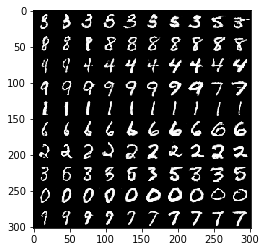

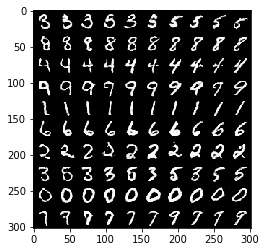

Epoch:7, Iter:0, Dloss: [ 1.188977], Gloss: [ 0.98860246], Preal: 0.5386109948158264, Pfake: 0.3691789507865906


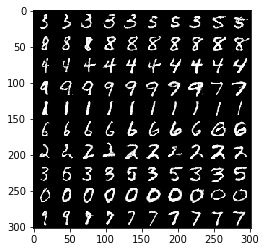

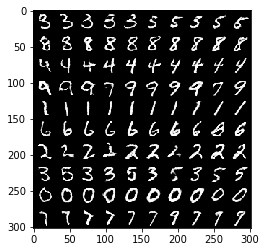

Epoch:7, Iter:100, Dloss: [ 1.15484393], Gloss: [ 0.89533007], Preal: 0.590793251991272, Pfake: 0.3893873989582062


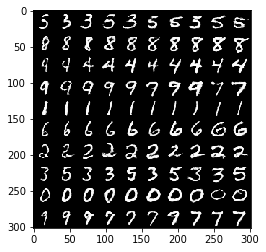

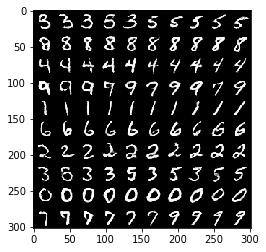

Epoch:7, Iter:200, Dloss: [ 1.18145216], Gloss: [ 0.88171053], Preal: 0.5725037455558777, Pfake: 0.38690099120140076


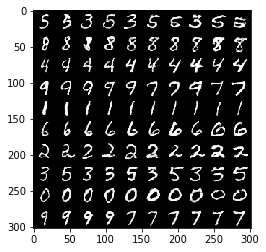

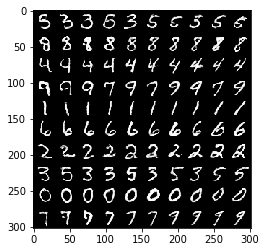

Epoch:7, Iter:300, Dloss: [ 1.14283037], Gloss: [ 0.93535101], Preal: 0.5709105134010315, Pfake: 0.3767696022987366


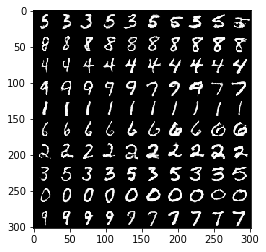

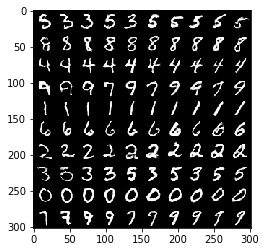

Epoch:7, Iter:400, Dloss: [ 1.2987113], Gloss: [ 0.84470159], Preal: 0.5512784719467163, Pfake: 0.408253014087677


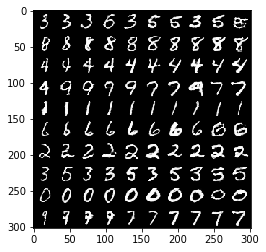

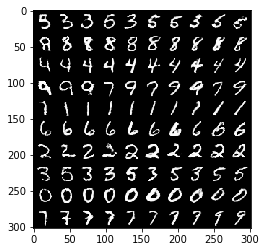

Epoch:7, Iter:500, Dloss: [ 1.24745965], Gloss: [ 0.92778289], Preal: 0.5283058881759644, Pfake: 0.38288769125938416


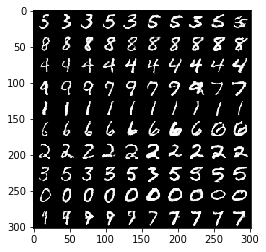

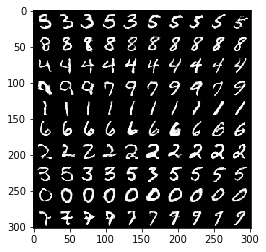

Epoch:8, Iter:0, Dloss: [ 1.19288206], Gloss: [ 0.89628768], Preal: 0.5858640074729919, Pfake: 0.3916851282119751


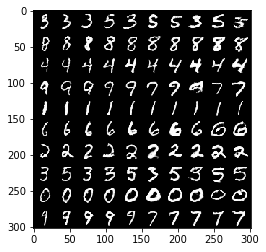

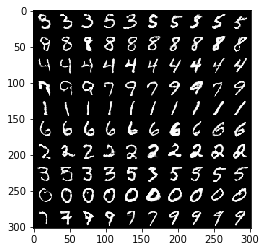

Epoch:8, Iter:100, Dloss: [ 1.19550824], Gloss: [ 0.96098393], Preal: 0.6016901135444641, Pfake: 0.37891125679016113


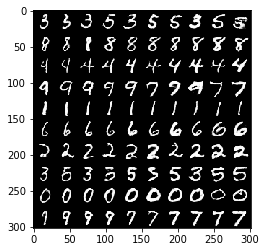

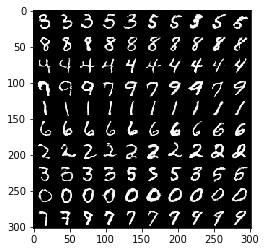

Epoch:8, Iter:200, Dloss: [ 1.16115808], Gloss: [ 0.98948044], Preal: 0.5587022304534912, Pfake: 0.3764950633049011


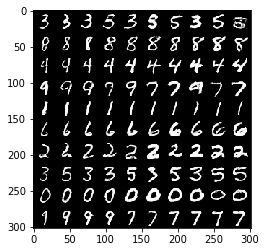

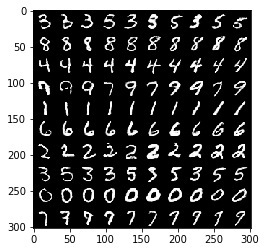

Process Process-36:
Process Process-33:
Process Process-34:
Process Process-35:
Traceback (most recent call last):
  File "/home/isjeon/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/isjeon/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/isjeon/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/isjeon/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/isjeon/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/isjeon/anaconda3/envs/py36/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
KeyboardInterrupt
Traceback (most rec

KeyboardInterrupt: 

In [16]:
for epoch in range(10):
    for num_iters, batch_data in enumerate(dataloader,0):
        real_labels = Variable(torch.ones(batch_size,1)).cuda()
        fake_labels = Variable(torch.zeros(batch_size,1)).cuda()
        
        # Train Discriminator D and Feature Extractor FE
        # real part
        x, _ = batch_data
        real_x = Variable(x.cuda())

        fe_out1 = FE(real_x)
        probs_real = D(fe_out1)
        loss_real = criterionD(probs_real, real_labels)

        # fake part
        dis_c = Variable(torch.FloatTensor(batch_size,10).cuda())
        con_c = Variable(torch.FloatTensor(batch_size,2).cuda())
        noise = Variable(torch.FloatTensor(batch_size,62).cuda())
        z, idx = _noise_sample(dis_c,con_c,noise,batch_size)

        fake_x = G(z)
        fe_out2 = FE(fake_x.detach())
        probs_fake = D(fe_out2)
        loss_fake = criterionD(probs_fake, fake_labels)

        D_loss = loss_real + loss_fake
        
        optimD.zero_grad()
        D_loss.backward()
        optimD.step()

        # Train Generator G and Clasifier Q (Lower bound of InfoMax Term)        
        fe_out = FE(fake_x)
        probs_fake = D(fe_out)
        G_loss = criterionD(probs_fake, real_labels)

        q_logits, q_mu, q_var = Q(fe_out)
        target_class = Variable(torch.LongTensor(idx).cuda())
        dis_loss = criterionQ_dis(q_logits, target_class)
        con_loss = criterionQ_con(con_c, q_mu, q_var)*0.1

        G_loss_with_InfoMax = G_loss + dis_loss + con_loss
        
        optimG.zero_grad()
        G_loss_with_InfoMax.backward()
        optimG.step()

        if num_iters % 100 == 0:
            print('Epoch:{0}, Iter:{1}, Dloss: {2}, Gloss: {3}, Preal: {4}, Pfake: {5}'.format(
                epoch, num_iters, D_loss.data.cpu().numpy(),
                G_loss_with_InfoMax.data.cpu().numpy(), probs_real.data.mean(), probs_fake.data.mean())
            )

            z = Variable(torch.cat([fix_noise, one_hot, c1], 1).view(-1, 74, 1, 1))
            x_save = G(z)
            
            if not os.path.exists('infoGan_out/'):
                os.makedirs('infoGan_out/')
            
            title1 = '(C1)'+str(epoch)+'_'+str(num_iters)
            save_image(x_save.data, 'infoGan_out/'+title1+'.png', nrow=10)
#             vf.imshow_multi(x_save.data.cpu(), nrow=10, title=title1,factor=1)
             
            plt.imshow(make_grid((x_save.data.cpu()), nrow=10).cpu().permute(1,2,0).numpy())
            plt.show()              
            
            z = Variable(torch.cat([fix_noise, one_hot, c2], 1).view(-1, 74, 1, 1))
            x_save = G(z)
            
            title2 = '(C2)'+str(epoch)+'_'+str(num_iters)
            save_image(x_save.data, 'infoGan_out/'+title2+'.png', nrow=10)
#             vf.imshow_multi(x_save.data.cpu(), nrow=10, title=title2,factor=1)
            
            plt.imshow(make_grid((x_save.data.cpu()), nrow=10).cpu().permute(1,2,0).numpy())
            plt.show()  
    